In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [2]:
# Initialize Spark Session from HDFS 
spark = SparkSession.builder \
    .appName("HIKARI Classification") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.hadoop.fs.hdfs.impl", "org.apache.hadoop.hdfs.DistributedFileSystem") \
    .getOrCreate()


In [3]:
print(spark.version)

3.5.0


In [4]:
PATH = "hdfs://namenode:9000/user/jovyan/input/hikari2021.csv"
df = spark.read.csv(PATH, header=True, inferSchema=True)   

In [5]:
df.take(10)

[Row(_c0=0, Unnamed: 0=0, uid='Cg61Jch3vdz9DBptj', originh='103.255.15.23', originp=13316, responh='128.199.242.104', responp=443, flow_duration=2.207588, fwd_pkts_tot=15, bwd_pkts_tot=14, fwd_data_pkts_tot=6, bwd_data_pkts_tot=6, fwd_pkts_per_sec=6.794746, bwd_pkts_per_sec=6.341763, flow_pkts_per_sec=13.136509, down_up_ratio=0.933333, fwd_header_size_tot=464, fwd_header_size_min=20, fwd_header_size_max=40, bwd_header_size_tot=492, bwd_header_size_min=32, bwd_header_size_max=44, flow_FIN_flag_count=2, flow_SYN_flag_count=2, flow_RST_flag_count=2, fwd_PSH_flag_count=6, bwd_PSH_flag_count=5, flow_ACK_flag_count=26, fwd_URG_flag_count=0, bwd_URG_flag_count=0, flow_CWR_flag_count=0, flow_ECE_flag_count=0, fwd_pkts_payload.min=0.0, fwd_pkts_payload.max=742.0, fwd_pkts_payload.tot=1826.0, fwd_pkts_payload.avg=121.733333, fwd_pkts_payload.std=220.736581, bwd_pkts_payload.min=0.0, bwd_pkts_payload.max=1448.0, bwd_pkts_payload.tot=5025.0, bwd_pkts_payload.avg=358.928571, bwd_pkts_payload.std=55

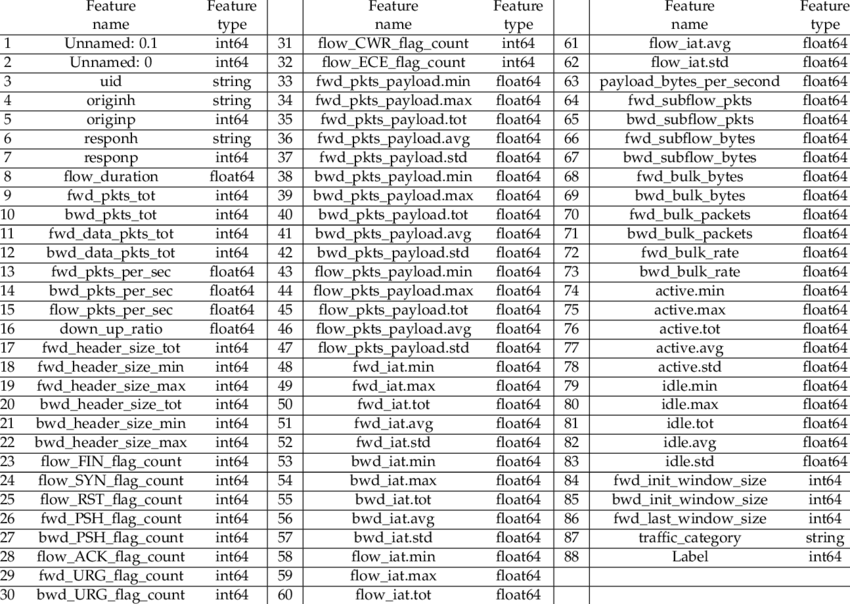

In [6]:
df.select("Label").distinct().show()

+-----+
|Label|
+-----+
|    1|
|    0|
+-----+



In [7]:
df.groupBy("traffic_category").count().orderBy("count", ascending=False).show()

+-------------------+------+
|   traffic_category| count|
+-------------------+------+
|             Benign|347431|
|         Background|170151|
|            Probing| 23388|
|         Bruteforce|  5884|
|     Bruteforce-XML|  5145|
|XMRIGCC CryptoMiner|  3279|
+-------------------+------+



In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- uid: string (nullable = true)
 |-- originh: string (nullable = true)
 |-- originp: integer (nullable = true)
 |-- responh: string (nullable = true)
 |-- responp: integer (nullable = true)
 |-- flow_duration: double (nullable = true)
 |-- fwd_pkts_tot: integer (nullable = true)
 |-- bwd_pkts_tot: integer (nullable = true)
 |-- fwd_data_pkts_tot: integer (nullable = true)
 |-- bwd_data_pkts_tot: integer (nullable = true)
 |-- fwd_pkts_per_sec: double (nullable = true)
 |-- bwd_pkts_per_sec: double (nullable = true)
 |-- flow_pkts_per_sec: double (nullable = true)
 |-- down_up_ratio: double (nullable = true)
 |-- fwd_header_size_tot: integer (nullable = true)
 |-- fwd_header_size_min: integer (nullable = true)
 |-- fwd_header_size_max: integer (nullable = true)
 |-- bwd_header_size_tot: integer (nullable = true)
 |-- bwd_header_size_min: integer (nullable = true)
 |-- bwd_header_size_max: integer (nul

In [9]:
# Mengganti nama semua kolom yang memiliki titik
new_columns = [col.replace(".", "_") for col in df.columns]
for old_col, new_col in zip(df.columns, new_columns):
    df = df.withColumnRenamed(old_col, new_col)

In [10]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- uid: string (nullable = true)
 |-- originh: string (nullable = true)
 |-- originp: integer (nullable = true)
 |-- responh: string (nullable = true)
 |-- responp: integer (nullable = true)
 |-- flow_duration: double (nullable = true)
 |-- fwd_pkts_tot: integer (nullable = true)
 |-- bwd_pkts_tot: integer (nullable = true)
 |-- fwd_data_pkts_tot: integer (nullable = true)
 |-- bwd_data_pkts_tot: integer (nullable = true)
 |-- fwd_pkts_per_sec: double (nullable = true)
 |-- bwd_pkts_per_sec: double (nullable = true)
 |-- flow_pkts_per_sec: double (nullable = true)
 |-- down_up_ratio: double (nullable = true)
 |-- fwd_header_size_tot: integer (nullable = true)
 |-- fwd_header_size_min: integer (nullable = true)
 |-- fwd_header_size_max: integer (nullable = true)
 |-- bwd_header_size_tot: integer (nullable = true)
 |-- bwd_header_size_min: integer (nullable = true)
 |-- bwd_header_size_max: integer (nul

In [11]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+----------+---+-------+-------+-------+-------+-------------+------------+------------+-----------------+-----------------+----------------+----------------+-----------------+-------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+-----------

In [12]:
originh_indexer = StringIndexer(inputCol="originh", outputCol="originh_index")
responh_indexer = StringIndexer(inputCol="responh", outputCol="responh_index")
traffic_indexer = StringIndexer(inputCol="traffic_category", outputCol="traffic_index")

In [13]:
traffic_indexer_model = traffic_indexer.fit(df)
# Ambil label urut dari model
labels = traffic_indexer_model.labels

# Tampilkan mapping index ke kategori
for i, label in enumerate(labels):
    print(f"Index {i} -> Kategori '{label}'")

Index 0 -> Kategori 'Benign'
Index 1 -> Kategori 'Background'
Index 2 -> Kategori 'Probing'
Index 3 -> Kategori 'Bruteforce'
Index 4 -> Kategori 'Bruteforce-XML'
Index 5 -> Kategori 'XMRIGCC CryptoMiner'


In [14]:
df = traffic_indexer.fit(df).transform(df)

In [15]:
df = df.drop("_c0", "Unnamed: 0", "uid", "Label")

In [16]:
numeric_columns = [col for col, dtype in df.dtypes if dtype in ("int", "double")]

In [17]:
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
# assembler = VectorAssembler(inputCols=numeric_columns, outputCol="raw_features")

In [18]:
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

In [19]:
import builtins
# Hitung jumlah total dan per kelas
label_counts = df.groupBy("traffic_index").count().collect()
print(label_counts)
total = builtins.sum([row["count"] for row in label_counts])

num_classes = len(label_counts)
class_weights = {
    row["traffic_index"]: total / (num_classes * row["count"])
    for row in label_counts
}
print(class_weights)

[Row(traffic_index=0.0, count=347431), Row(traffic_index=1.0, count=170151), Row(traffic_index=4.0, count=5145), Row(traffic_index=3.0, count=5884), Row(traffic_index=2.0, count=23388), Row(traffic_index=5.0, count=3279)]
{0.0: 0.26637327507716163, 1.0: 0.5439070786144856, 4.0: 17.987625526401036, 3.0: 15.72847269431226, 2.0: 3.957000741120803, 5.0: 28.223950391379486}


In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def get_weight(label):
    return float(class_weights[label])

weight_udf = udf(get_weight, DoubleType())
df_weighted = df.withColumn("classWeight", weight_udf(col("traffic_index")))

In [21]:
rf = RandomForestClassifier(
    labelCol="traffic_index",
    featuresCol="features",
    weightCol="classWeight",
    numTrees=100,
    maxDepth=5,
    seed=42
)

# gbt = GBTClassifier(
#     labelCol="traffic_index",
#     featuresCol="features",
#     weightCol="classWeight",
#     maxIter=50              
# )

# svc = LinearSVC(
#     featuresCol="features",
#     labelCol="traffic_index",
#     weightCol="classWeight",
#     maxIter=20,
#     regParam=0.1
# )

In [22]:
# OvR Wrapper 
# ovr = OneVsRest(
#     classifier=gbt, # or svc
#     labelCol="traffic_index",
#     featuresCol="features",
#     predictionCol="prediction"
# )

In [23]:
pipeline = Pipeline(stages=[
    originh_indexer,
    responh_indexer,
    assembler,
    # scaler,
    rf
])

# pipeline = Pipeline(stages=[
#     originh_indexer,
#     responh_indexer,
#     assembler,
#     ovr
# ])

In [24]:
train_data, test_data = df_weighted.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

In [25]:
pred = model.transform(test_data)

In [26]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="traffic_index",
    predictionCol="prediction",
    metricName="f1"
)

f1_score = evaluator.evaluate(pred)
print("Weighted F1 Score:", f1_score)

Weighted F1 Score: 0.8406156851654539


In [27]:
confusion = (
    pred.groupBy("traffic_index")
    .pivot("prediction")
    .count()
    .fillna(0)
    .orderBy("traffic_index")
)
confusion.show()

+-------------+-----+-----+-----+----+----+---+
|traffic_index|  0.0|  1.0|  2.0| 3.0| 4.0|5.0|
+-------------+-----+-----+-----+----+----+---+
|          0.0|50083| 4963|12127|1337|1021|  0|
|          1.0|    7|33279|   24| 314|   2|529|
|          2.0|    0|   18| 4604|   0|   0|  0|
|          3.0|    0|    2|    0|1217|   0|  0|
|          4.0|    0|    0|    0|   0|1034|  0|
|          5.0|    0|    0|    0|   0|   0|661|
+-------------+-----+-----+-----+----+----+---+



In [28]:
from pyspark.sql import functions as F

pred_cols = confusion.columns[1:]  # semua kolom prediksi selain label

# langsung pakai stack tanpa select bertingkat
conf_long = confusion.select(
    F.col("traffic_index").alias("labelIndex"),
    F.expr(
        f"stack({len(pred_cols)}, " +
        ", ".join([f"'{c}', `{c}`" for c in pred_cols]) +
        ") as (prediction, count)"
    )
).filter(F.col("count") > 0)

conf_long.show(5, False)


+----------+----------+-----+
|labelIndex|prediction|count|
+----------+----------+-----+
|0.0       |0.0       |50083|
|0.0       |1.0       |4963 |
|0.0       |2.0       |12127|
|0.0       |3.0       |1337 |
|0.0       |4.0       |1021 |
+----------+----------+-----+
only showing top 5 rows



In [30]:
# Semua kelas label dan prediksi (asumsi sama)
classes = [float(c) for c in pred_cols]

from pyspark.sql import Window

# TP per kelas
tp = conf_long.filter(F.col("labelIndex") == F.col("prediction")) \
    .select("labelIndex", F.col("count").alias("TP"))

# FP per kelas = sum count where prediction=k but labelIndex != k
fp = conf_long.filter(F.col("labelIndex") != F.col("prediction")) \
    .groupBy("prediction") \
    .agg(F.sum("count").alias("FP")) \
    .withColumnRenamed("prediction", "labelIndex")

# FN per kelas = sum count where labelIndex=k but prediction != k
fn = conf_long.filter(F.col("labelIndex") != F.col("prediction")) \
    .groupBy("labelIndex") \
    .agg(F.sum("count").alias("FN"))

# Gabungkan TP, FP, FN
metrics = tp.join(fp, "labelIndex", "full_outer") \
            .join(fn, "labelIndex", "full_outer") \
            .na.fill(0)

metrics.show()


+----------+-----+-----+-----+
|labelIndex|   TP|   FP|   FN|
+----------+-----+-----+-----+
|       0.0|50083|    7|19448|
|       1.0|33279| 4983|  876|
|       2.0| 4604|12151|   18|
|       3.0| 1217| 1651|    2|
|       4.0| 1034| 1023|    0|
|       5.0|  661|  529|    0|
+----------+-----+-----+-----+



In [31]:
metrics = metrics.withColumn("precision", 
    F.when((F.col("TP") + F.col("FP")) > 0, F.col("TP") / (F.col("TP") + F.col("FP"))) \
     .otherwise(0)
).withColumn("recall", 
    F.when((F.col("TP") + F.col("FN")) > 0, F.col("TP") / (F.col("TP") + F.col("FN"))) \
     .otherwise(0)
).withColumn("f1", 
    F.when((F.col("precision") + F.col("recall")) > 0, 
           2 * F.col("precision") * F.col("recall") / (F.col("precision") + F.col("recall"))) \
     .otherwise(0)
)

metrics.show()


+----------+-----+-----+-----+-------------------+------------------+------------------+
|labelIndex|   TP|   FP|   FN|          precision|            recall|                f1|
+----------+-----+-----+-----+-------------------+------------------+------------------+
|       0.0|50083|    7|19448|  0.999860251547215| 0.720297421294099|0.8373613328763343|
|       1.0|33279| 4983|  876|  0.869766347812451|0.9743522178304787|0.9190935829984671|
|       2.0| 4604|12151|   18|0.27478364667263505|0.9961055819991346|0.4307433222622445|
|       3.0| 1217| 1651|    2|0.42433751743375175|0.9983593109105825| 0.595546855884512|
|       4.0| 1034| 1023|    0| 0.5026737967914439|               1.0|0.6690391459074733|
|       5.0|  661|  529|    0| 0.5554621848739496|               1.0|0.7142085359265262|
+----------+-----+-----+-----+-------------------+------------------+------------------+



In [32]:
f1_macro = metrics.agg(F.mean("f1").alias("f1_macro")).collect()[0]["f1_macro"]
print(f"F1 Macro: {f1_macro:.4f}")

F1 Macro: 0.6943
